# Homework 1

> 编辑日期：2023/05/11

## 1 Data Source

- 本数据来源于 Kaggle ，包含了 570 种 cancer cell 的 30 个 feature信息 所有的数据被标记为两类:

    - Benign Cancer (B)
    - Malignant Cancer (M) 

- CSV 中各字段类型如下:

    - Col 0 为该记录的 id (String)
    - Col 1 为该记录的 class(B/M)
    - Col 2~31 为记录的 30 个其余 feature 信息 (Float)

In [1]:
import csv

data_file = 'Cancer_Data.csv'

try:
      f = open(data_file, encoding='utf-8')
except:
	print(f'Fail to open file "{data_file}"')
        
reader = csv.reader(f)
header = next(reader)
n_cols = len(header)

print(f"本数据集共有 {n_cols} 个字段：")
for idx, key in enumerate(header):
      print("  ", '{0:<2}'.format(idx), key)


本数据集共有 32 个字段：
   0  id
   1  diagnosis
   2  radius_mean
   3  texture_mean
   4  perimeter_mean
   5  area_mean
   6  smoothness_mean
   7  compactness_mean
   8  concavity_mean
   9  concave points_mean
   10 symmetry_mean
   11 fractal_dimension_mean
   12 radius_se
   13 texture_se
   14 perimeter_se
   15 area_se
   16 smoothness_se
   17 compactness_se
   18 concavity_se
   19 concave points_se
   20 symmetry_se
   21 fractal_dimension_se
   22 radius_worst
   23 texture_worst
   24 perimeter_worst
   25 area_worst
   26 smoothness_worst
   27 compactness_worst
   28 concavity_worst
   29 concave points_worst
   30 symmetry_worst
   31 fractal_dimension_worst


## 2 Data Processing

### 2.1 转化数据格式

- 由于 `id` 字段对于构建分类器没有帮助，此处我们不予保留
- 由于本数据集中 `diagnose` 字段仅有 `M / B` 两种取值，为方便计算，此处分别将两种取值替换为 `0 / 1`

In [2]:
#  初始化
total = 0                     # 数据总量
original_data = []            # 存储原始数据，Col_N 存储在数组 original_data[N] 中
count_null = [0] * (n_cols-1) # 统计空数据信息

for i in range(1, n_cols):
    original_data.append([])

for row in reader:
    total += 1
    flag = True
    for idx in range(1, n_cols):
        if not row[idx]:
            count_null[idx] += 1
            flag = False
    if flag:
        for i in range(1, n_cols):
            if(i==1):
                if (row[1][0] == 'M'):
                    original_data[0].append(0)
                else:
                    original_data[0].append(1)
            else:
                original_data[i-1].append(float(row[i]))

f.close()

### 2.2 Handle Missing Value

数据缺失信息的统计实现在上一个代码块，此处仅展示统计结果。

不幸的是，本数据集的内容非常完整，不需要进行补全

In [3]:
print(f"本数据集共有 {len(original_data[0])} / {total} 条完整数据，空缺详情如下")
for idx in range(0, n_cols-1):
    print("  ", '{0:<4}'.format(idx), '{0:<25}'.format(header[idx+1]), count_null[idx])

本数据集共有 569 / 569 条完整数据，空缺详情如下
   0    diagnosis                 0
   1    radius_mean               0
   2    texture_mean              0
   3    perimeter_mean            0
   4    area_mean                 0
   5    smoothness_mean           0
   6    compactness_mean          0
   7    concavity_mean            0
   8    concave points_mean       0
   9    symmetry_mean             0
   10   fractal_dimension_mean    0
   11   radius_se                 0
   12   texture_se                0
   13   perimeter_se              0
   14   area_se                   0
   15   smoothness_se             0
   16   compactness_se            0
   17   concavity_se              0
   18   concave points_se         0
   19   symmetry_se               0
   20   fractal_dimension_se      0
   21   radius_worst              0
   22   texture_worst             0
   23   perimeter_worst           0
   24   area_worst                0
   25   smoothness_worst          0
   26   compactness_worst         

`diagnose` 字段中各类型数据占比情况如下：

/var/folders/bv/mc555hkn509dv41d0yq119jr0000gn/T/ipykernel_46510/676113794.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


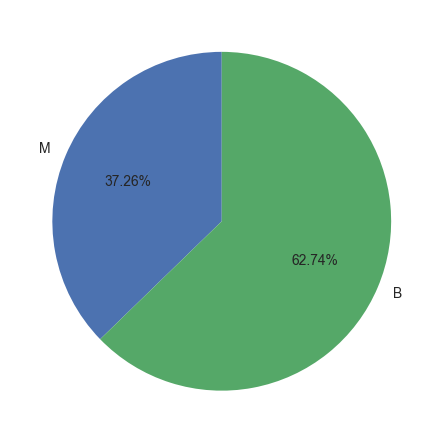

In [4]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.pie([original_data[0].count(0), original_data[0].count(1)], labels=["M", "B"], autopct='%1.2f%%', startangle=90)
plt.show()

### 2.3 Remove Outliers

为原始数据绘制箱线图，检查 outliers 的分布状态

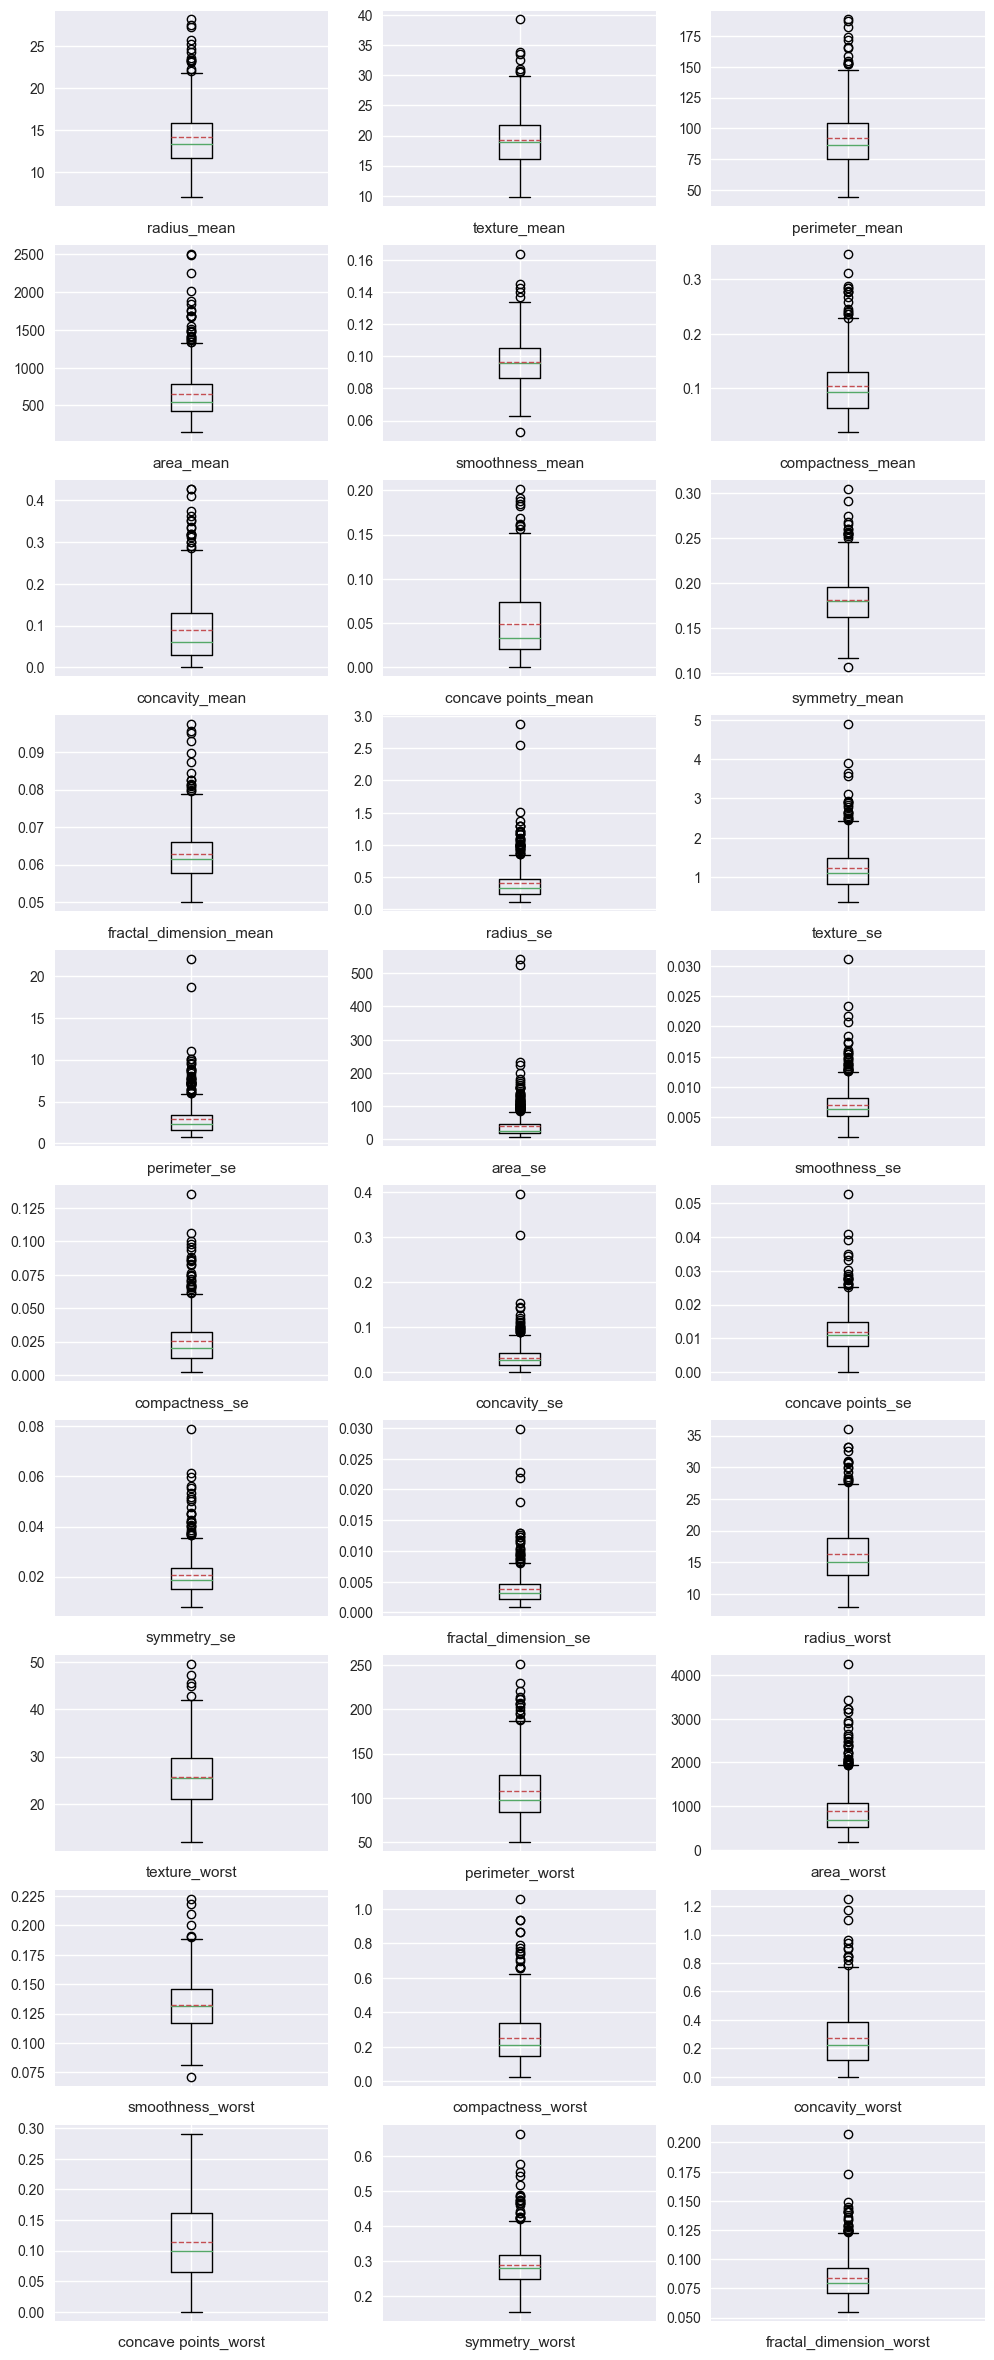

In [5]:
# 原始数据箱线图
plt.figure(figsize=(12,30))
for i in range(0, 30):
    ax = plt.subplot(10, 3, i+1)
    ax.set_xlabel(header[i+2])
    ax.set_xticks(range(0,1))
    ax.boxplot(original_data[i+1],
               showmeans=True,
               meanline=True)

显然，除 `concave points_worst` 外，各 Feature 均在不同程度上存在 outlier。

下面标记存在 outlier 的记录，并进行移除。

In [6]:
import math

q1_pos, q3_pos = math.floor(total*0.25), math.ceil(total*0.75)

lowers, uppers = [], []
for i in range(0,30):
    q1 = sorted(original_data[i+1])[q1_pos]
    q3 = sorted(original_data[i+1])[q3_pos]
    iqr = q3 - q1
    lowers.append(q1-1.5*iqr)
    uppers.append(q3+1.5*iqr)


outlier_rm = []
for i in range(0,31):
    outlier_rm.append([])

removed = []
for i in range(0, total):
    flag = True
    for j in range(0, 30):
        val = original_data[j+1][i]
        lower = lowers[j]
        upper = uppers[j]
        if val < lower or val > upper:
            flag = False
            break
    if flag:
        for j in range(0, 31):
            outlier_rm[j].append(original_data[j][i])
    else:
        removed.append(i)

print(f"{len(removed)} ({'{:.2f}'.format(len(removed)/total*100)}%) lines has been removed, detail is as follows:")
print(removed)

169 (29.70%) lines has been removed, detail is as follows:
[0, 1, 2, 3, 4, 5, 8, 9, 12, 14, 15, 18, 22, 23, 24, 25, 26, 27, 30, 31, 33, 34, 35, 38, 41, 42, 53, 56, 60, 62, 63, 68, 70, 71, 72, 76, 77, 78, 82, 83, 95, 105, 108, 110, 111, 112, 116, 118, 119, 121, 122, 136, 138, 145, 146, 147, 150, 151, 152, 156, 161, 162, 164, 168, 173, 176, 180, 181, 185, 190, 192, 196, 199, 202, 203, 210, 212, 213, 214, 218, 219, 229, 232, 236, 239, 242, 245, 250, 252, 254, 256, 257, 258, 259, 262, 265, 272, 273, 275, 288, 290, 300, 302, 314, 318, 323, 329, 332, 335, 337, 339, 343, 345, 351, 352, 366, 368, 369, 370, 372, 376, 379, 388, 389, 391, 393, 400, 416, 417, 424, 430, 433, 443, 449, 450, 455, 460, 461, 465, 468, 469, 471, 473, 485, 489, 492, 498, 503, 504, 505, 507, 520, 521, 528, 533, 535, 537, 539, 553, 556, 557, 559, 561, 562, 563, 564, 565, 567, 568]


## 3 Data Reduction

### 3.1 Feature Selection

使用 Variace Threshold Filtering 进行数据降维

In [7]:
# 仅对后 30 个 Feature 进行筛选
vairances = []
for i in range(1, len(original_data)):
    avg = sum(original_data[i])/total
    tot = 0
    for j in range(0, total):
        tot += (original_data[i][j] - avg)*(original_data[i][j] - avg)
    vairances.append(tot/total)

In [8]:
# 输出不同阈值取值对筛选结果的影响
thresholds = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2, 4, 8, 10, 15, 650]
percentages = []

print('{0:^11}'.format("Threshold"), '{0:^10}'.format('N-Feature'), '{0:^12}'.format("Percentage"), "  " , "Feature List")
print("---------------------------------------------------------------------------------------------------")

for i in range(0, len(thresholds)):
    threshold = thresholds[i]
    selected = []
    for j in range(0, len(vairances)):
        if vairances[j] > threshold:
            selected.append(j+1)
    percentages.append(len(selected)/30*100)
    print('{0:^11}'.format(threshold), '{0:^10}'.format(len(selected)), '{0:^12}'.format('{0:.2f}'.format(percentages[i]) + "%"), "  " , selected)

 Threshold  N-Feature   Percentage     Feature List
---------------------------------------------------------------------------------------------------
  0.0001        25        83.33%       [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
   0.001        19        63.33%       [1, 2, 3, 4, 6, 7, 8, 11, 12, 13, 14, 21, 22, 23, 24, 26, 27, 28, 29]
   0.01         14        46.67%       [1, 2, 3, 4, 11, 12, 13, 14, 21, 22, 23, 24, 26, 27]
    0.1         11        36.67%       [1, 2, 3, 4, 12, 13, 14, 21, 22, 23, 24]
    0.5         10        33.33%       [1, 2, 3, 4, 13, 14, 21, 22, 23, 24]
     1          10        33.33%       [1, 2, 3, 4, 13, 14, 21, 22, 23, 24]
     2          10        33.33%       [1, 2, 3, 4, 13, 14, 21, 22, 23, 24]
     4          10        33.33%       [1, 2, 3, 4, 13, 14, 21, 22, 23, 24]
     8          9         30.00%       [1, 2, 3, 4, 14, 21, 22, 23, 24]
    10          9         30.00%       [1, 2, 3, 4, 14, 21, 

Threshold 取值与 Featrue 筛选数量的关系如下图所示：

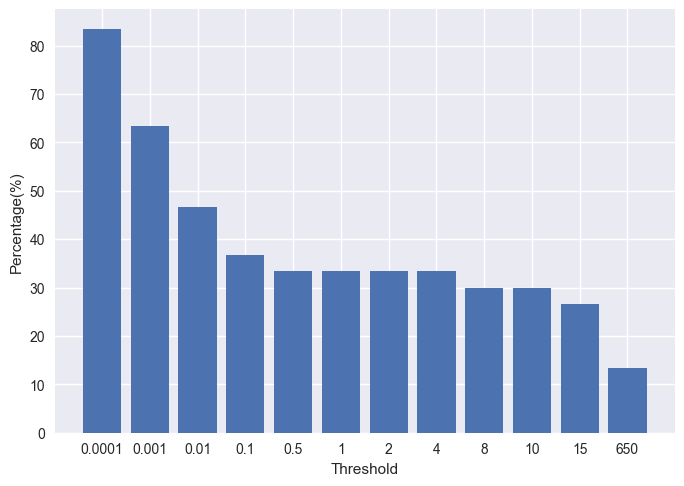

In [9]:
ax = plt.subplot()
ax.bar(range(len(thresholds)), percentages)
ax.set_xlabel('Threshold')
ax.set_xticks(range(0, len(thresholds)))
ax.set_xticklabels([str(i) for i in thresholds])
ax.set_ylabel('Percentage(%)')
plt.show()

以上是对于原始数据的筛选结果，下面尝试对去除 outlier 的数据进行筛选：

In [10]:
# 计算方差
vairances = []
total = len(outlier_rm[0])
for i in range(1, 31):
    avg = sum(outlier_rm[i])/total
    tot = 0
    for j in range(0, total):
        tot += (outlier_rm[i][j] - avg)*(outlier_rm[i][j] - avg)
    vairances.append(tot/total)

# 不同阈值取值对筛选结果的影响
percentages = []

print('{0:^11}'.format("Threshold"), '{0:^10}'.format('N-Feature'), '{0:^12}'.format("Percentage"), "  " , "Feature List")
print("---------------------------------------------------------------------------------------------------")

for i in range(0, len(thresholds)):
    threshold = thresholds[i]
    selected = []
    for j in range(0, len(vairances)):
        if vairances[j] > threshold:
            selected.append(j+1)
    percentages.append(len(selected)/30*100)
    print('{0:^11}'.format(threshold), '{0:^10}'.format(len(selected)), '{0:^12}'.format('{0:.2f}'.format(percentages[i]) + "%"), "  " , selected)

 Threshold  N-Feature   Percentage     Feature List
---------------------------------------------------------------------------------------------------
  0.0001        25        83.33%       [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
   0.001        18        60.00%       [1, 2, 3, 4, 6, 7, 11, 12, 13, 14, 21, 22, 23, 24, 26, 27, 28, 29]
   0.01         14        46.67%       [1, 2, 3, 4, 11, 12, 13, 14, 21, 22, 23, 24, 26, 27]
    0.1         11        36.67%       [1, 2, 3, 4, 12, 13, 14, 21, 22, 23, 24]
    0.5         10        33.33%       [1, 2, 3, 4, 13, 14, 21, 22, 23, 24]
     1          9         30.00%       [1, 2, 3, 4, 14, 21, 22, 23, 24]
     2          9         30.00%       [1, 2, 3, 4, 14, 21, 22, 23, 24]
     4          9         30.00%       [1, 2, 3, 4, 14, 21, 22, 23, 24]
     8          8         26.67%       [2, 3, 4, 14, 21, 22, 23, 24]
    10          8         26.67%       [2, 3, 4, 14, 21, 22, 23, 24]
    15   

对比前表可知，在相同的 Threshold 下，对去除 outlier 的数据集进行筛选将保留 **更多的 Feature** 。

### 3.2 Histogram Analysis

通过绘制去除 outlier 数据的 equl-width 直方图，观察数据分布情况。

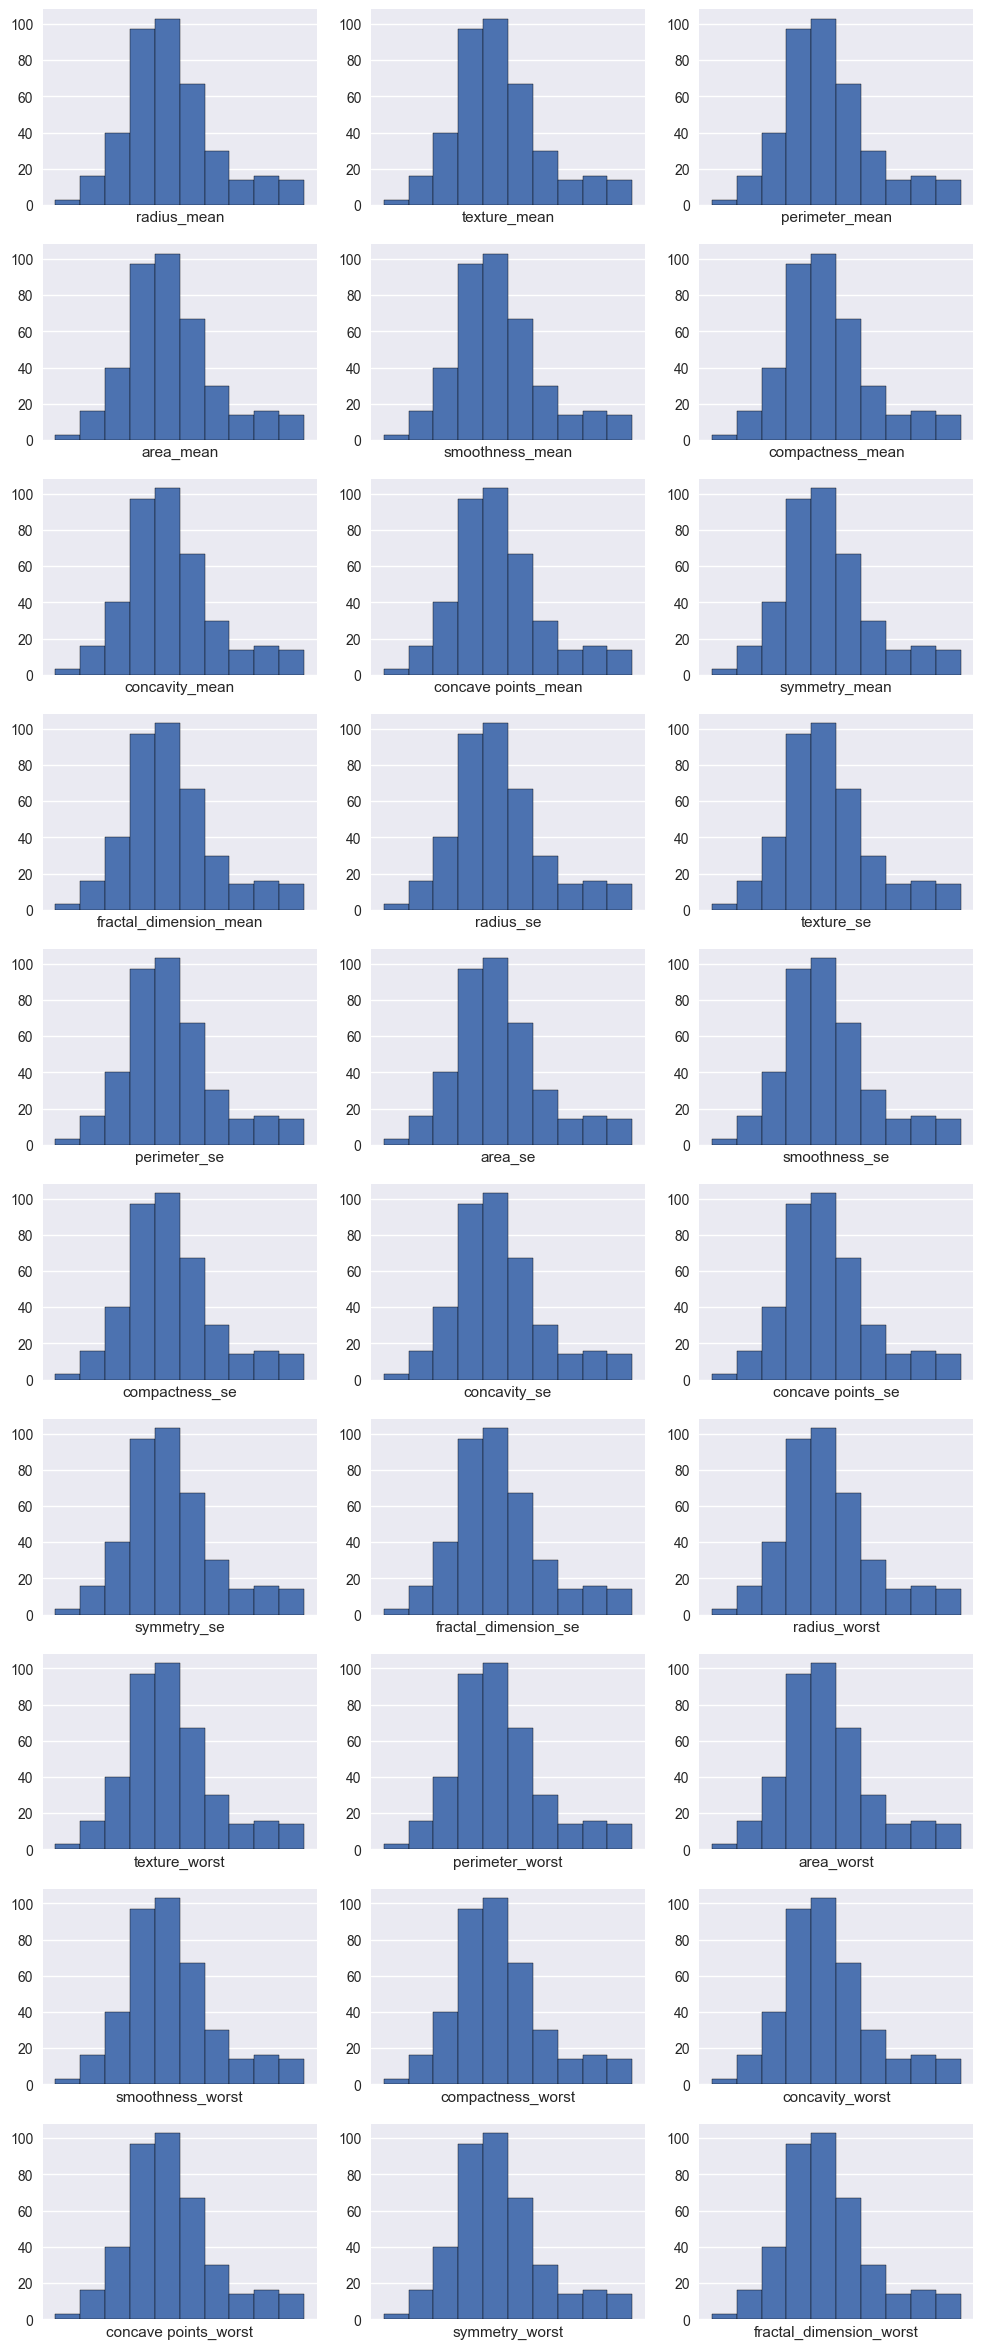

In [11]:
# 去除 outlier 数据的直方图
plt.figure(figsize=(12,30))
for i in range(0, 30):
    ax = plt.subplot(10, 3, i+1)
    ax.set_xlabel(header[i+2])
    ax.set_xticks(range(0,1))
    ax.hist(outlier_rm[1], edgecolor="black")

从上图可知，去除 outlier 后的各 Feature 数据基本符合正态分布，下面通过 Q-Q 图进行验证：

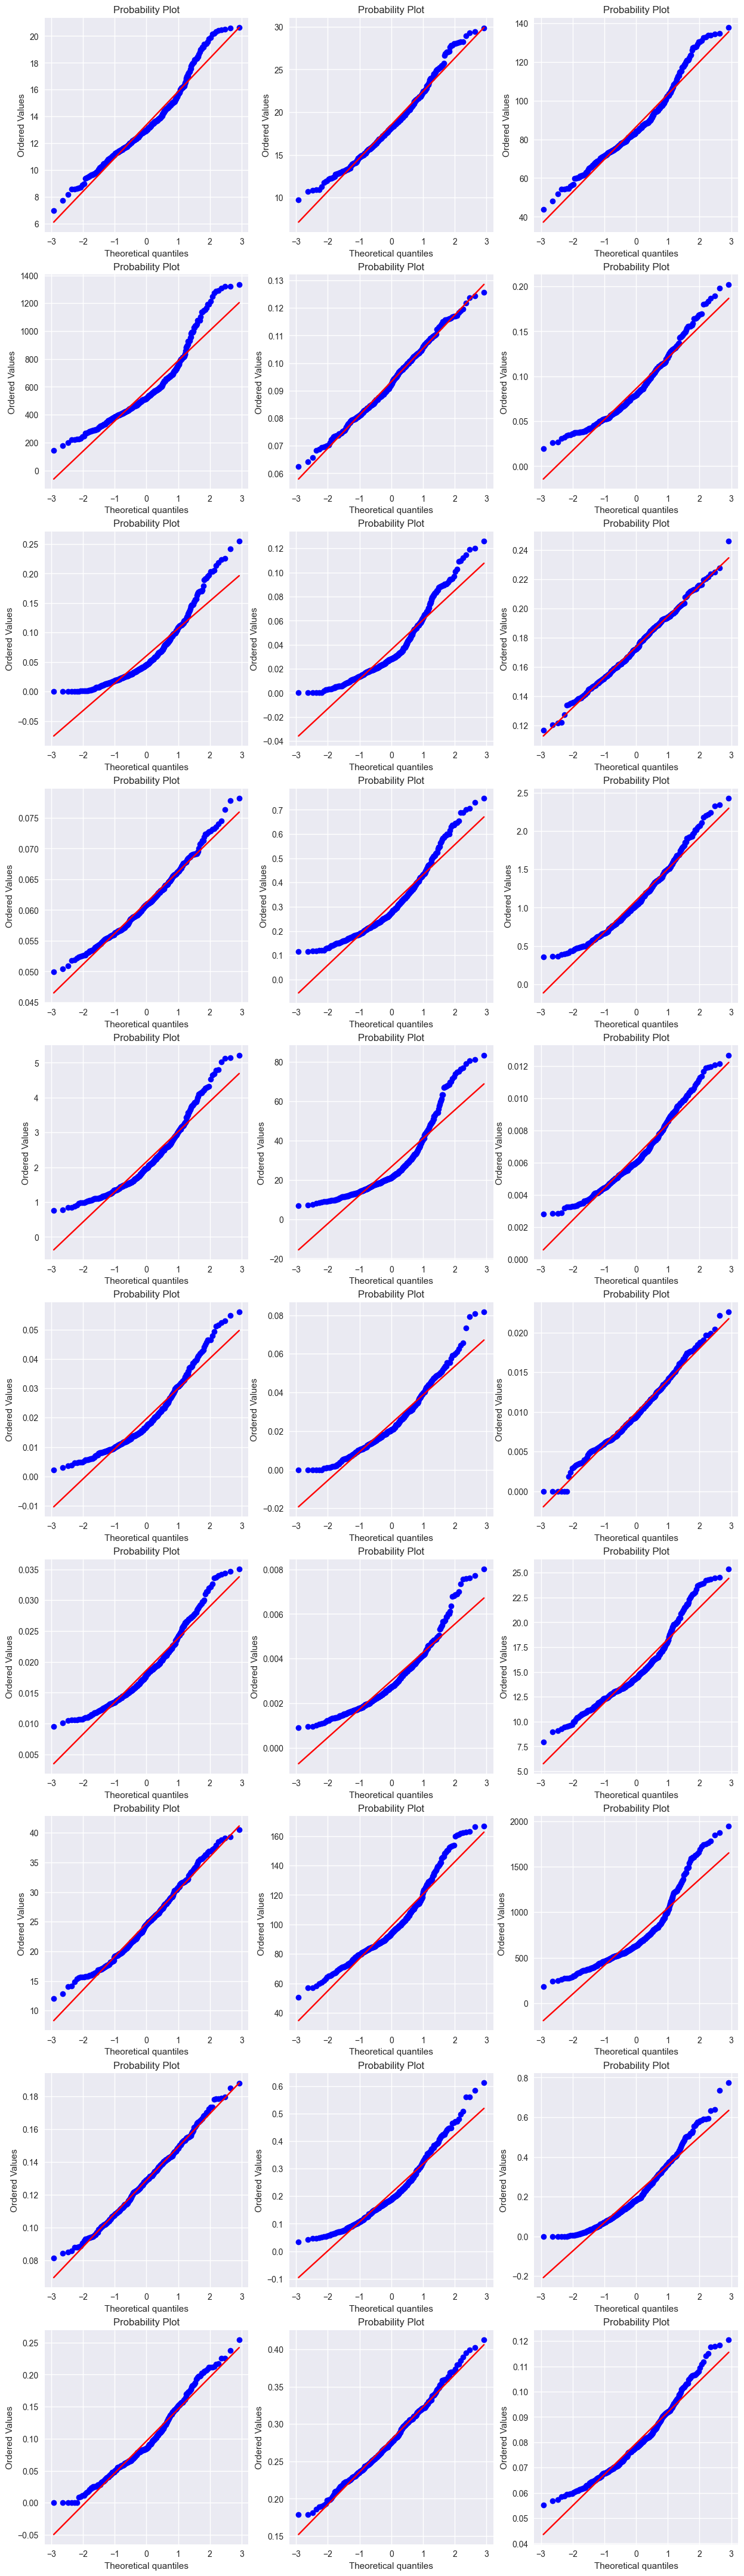

In [12]:
# 绘制各 Feature 的 Q-Q 图
from scipy import stats
plt.figure(figsize=(15,55))

for i in range(0,30):
    ax = plt.subplot(10, 3, i+1)
    # 没办法设小标题（我裂开）
    stats.probplot(outlier_rm[i+1], dist="norm", plot=ax)

plt.show()

## 4 Data Transformation

由于不同的 `diagnose` 组别间的数据可能满足不同的正态分布，下面通过 MinMax 方式对数据进行标准化：

$$
    x_{norm} = \frac{x - x_{min}}{x_{max} - x{min}}
$$

In [13]:
# 统计每个属性的 min / max 值
mins = [0]
maxs = [1]

print("各属性取值的 min / max 信息如下：")
print('{0:^24}'.format("Attribute Name"), '{0:^10}'.format("min"), '{0:^10}'.format("max"))
print("----------------------------------------------")

for i in range(1, len(outlier_rm)):
    minn = min(outlier_rm[i])
    maxx = max(outlier_rm[i])
    mins.append(minn)
    maxs.append(maxx)
    print('{0:^24}'.format(header[i]), '{0:^10}'.format(minn), '{0:^10}'.format(maxx))

各属性取值的 min / max 信息如下：
     Attribute Name         min        max    
----------------------------------------------
       diagnosis           6.981      20.64   
      radius_mean           9.71      29.81   
      texture_mean         43.79      137.8   
     perimeter_mean        143.5      1335.0  
       area_mean          0.06251     0.1257  
    smoothness_mean       0.01938     0.2022  
    compactness_mean        0.0       0.2545  
     concavity_mean         0.0       0.1259  
  concave points_mean      0.1167     0.2459  
     symmetry_mean        0.04996    0.07818  
 fractal_dimension_mean    0.1144     0.7474  
       radius_se           0.3602     2.426   
       texture_se          0.757      5.216   
      perimeter_se         6.802       83.5   
        area_se           0.002826   0.01266  
     smoothness_se        0.002252   0.05592  
     compactness_se         0.0      0.08158  
      concavity_se          0.0      0.02258  
   concave points_se      0.009539   

In [14]:
# 对数据进行标准化
normalized_data = []
for i in range(0, 31):
    normalized_data.append([])

for i in range(0, total):
    normalized_data[0].append(outlier_rm[0][i])
    for j in range(1, 31):
        normalized_data[j].append((outlier_rm[j][i] - mins[j])/(maxs[j] - mins[j]))

下面重新计算输出经过 MinMax 标准化后，各 Feature 字段的最大最小值以验证操作的正确性。

In [15]:
print("完成标准化后，各属性取值的 min / max 信息如下：")
print('{0:^24}'.format("Attribute Name"), '{0:^10}'.format("min"), '{0:^10}'.format("max"))
print("----------------------------------------------")

for i in range(1, len(normalized_data)):
    minn = min(normalized_data[i])
    maxx = max(normalized_data[i])
    print('{0:^24}'.format(header[i]), '{0:^10}'.format(minn), '{0:^10}'.format(maxx))

完成标准化后，各属性取值的 min / max 信息如下：
     Attribute Name         min        max    
----------------------------------------------
       diagnosis            0.0        1.0    
      radius_mean           0.0        1.0    
      texture_mean          0.0        1.0    
     perimeter_mean         0.0        1.0    
       area_mean            0.0        1.0    
    smoothness_mean         0.0        1.0    
    compactness_mean        0.0        1.0    
     concavity_mean         0.0        1.0    
  concave points_mean       0.0        1.0    
     symmetry_mean          0.0        1.0    
 fractal_dimension_mean     0.0        1.0    
       radius_se            0.0        1.0    
       texture_se           0.0        1.0    
      perimeter_se          0.0        1.0    
        area_se             0.0        1.0    
     smoothness_se          0.0        1.0    
     compactness_se         0.0        1.0    
      concavity_se          0.0        1.0    
   concave points_se        0.

从上表可知，经过 MinMax 标准化后，所有 Feature 的取值均处于区间 `[0,1]` 内。